# CycleGAN for Animal to Animal Style Transfer

This notebook demonstrates unpaired image to image translation using conditional GAN's, as described in [Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks](https://arxiv.org/abs/1703.10593), also known as CycleGAN. The paper proposes a method that can capture the characteristics of one image domain and figure out how these characteristics could be translated into another image domain, all in the absence of any paired training examples. 

The "cycle" in CycleGan, referrs to cycle consistency loss to enable training without the need for paired data. In other words, it can translate from one domain to another without a one-to-one mapping between the source and target domain. This opens up the possibility to do a lot of interesting tasks like photo-enhancement, image colorization, and in my case, style transfering giraffes onto other animals. All you need is two directories and the help of this tutorial to get you started!

![Output Image 1](https://github.com/westontscott/Capstone-Projects/blob/master/Animal2Aminal%20Style%20Transfer/Images/h2g.JPG?raw=1)
![Output Image 2](https://github.com/westontscott/Capstone-Projects/blob/master/Animal2Aminal%20Style%20Transfer/Images/g2h_8.JPG?raw=1)
![Output Image 3](https://github.com/westontscott/Capstone-Projects/blob/master/Animal2Aminal%20Style%20Transfer/Images/z2g_3.JPG?raw=1)
![Output Image 3](https://github.com/westontscott/Capstone-Projects/blob/master/Animal2Aminal%20Style%20Transfer/Images/z2g_6.JPG?raw=1)

## Set up the input pipeline

After attempting to run this code on my own local machine, I realized my GPU wasn't going to cut it. From there I decided to leverage Google Colabs free Tesla K80 GPU to train my neural network. This meant that I needed to mount my Google Drive to save my progress whenever my hosted runntime was running out.

In [88]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf


sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7



In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Install the [tensorflow_examples](https://github.com/tensorflow/examples) package that enables importing of the generator and the discriminator.

In [90]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-4bl9l2pf
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-4bl9l2pf
  Created wheel for tensorflow-examples: filename=tensorflow_examples-88f745838f7f5bda72a8ee43fd84771e466b22b8_-cp36-none-any.whl size=45164 sha256=4f75777908d0db463e7e5643a5acc239c793b284e3c313fd41e6223163d8ba74
  Stored in directory: /tmp/pip-ephem-wheel-cache-zdw2f6lj/wheels/83/64/b3/4cfa02dc6f9d16bf7257892c6a7ec602cd7e0ff6ec4d7d714d
Successfully built tensorflow-examples


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix
#from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

tfds.disable_progress_bar()
AUTOTUNE = tf.data.experimental.AUTOTUNE

## Input Pipeline

This tutorial trains a model to translate images of horses to images of zebras while also incorporating a pipeline to translate any animal2animal. The horse and zebra images are from TensorFlow Datasets, while the giraffe images were gathered myself leveraging a google images api. 

As mentioned in the [paper](https://arxiv.org/abs/1703.10593), I will be applying random jittering and mirroring to the training dataset to help alleviate overfitting.

This is similar to what was done in [pix2pix](https://www.tensorflow.org/tutorials/generative/pix2pix#load_the_dataset)

* In random jittering, the image is resized to `286 x 286` and then randomly cropped to `256 x 256`.
* In random mirroring, the image is randomly flipped horizontally i.e left to right.

In [0]:
#Pulling in images from TensorFlow Datasets
dataset, metadata = tfds.load('cycle_gan/horse2zebra',
                              with_info=True, as_supervised=True)

train_horses, train_zebras = dataset['trainA'], dataset['trainB']
test_horses, test_zebras = dataset['testA'], dataset['testB']


# To match the 600 images in the giraffe dataset, here we take 600 in the Tensorflow dataset
train_horses = train_horses.take(600)
train_zebras = train_zebras.take(600)

I have already created a pipeline for gathering images from google and resizing them to 256 x 256. This process can be found in my [repository](https://github.com/westontscott/Capstone-Projects/blob/master/Animal2Aminal%20Style%20Transfer/google_images_api_pipeline.ipynb). From there, I've uploaded them directly to my mounted Google Drive.

In [0]:
import glob

# Train Giraffe Filenames
train_filenames = glob.glob("/content/drive/My Drive/Giraffe Images/train_giraffes/train_giraffes/*", recursive= True)

# Test Giraffe Filenames
test_filenames = glob.glob("/content/drive/My Drive/Giraffe Images/test_giraffes/test_giraffes/*", recursive= True)


train_data = tf.data.Dataset.from_tensor_slices(
  (tf.constant(train_filenames))
)

# Making a dataset of 600 images 
train_data = train_data.take(600)


test_data = tf.data.Dataset.from_tensor_slices(
  (tf.constant(test_filenames))
)

In [0]:

# Initializine our buffer size, batch size, and image dimensoins for preprocessing
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [0]:
#Randomly cropping images to 256 x 256
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [0]:
# Normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [0]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [0]:
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [0]:
# No need to apply random jitter to test images, as the model will not be
# overfit to them
def preprocess_image_test(image, label):
  image = normalize(image)
  return image

Unfortunately, my images weren't quite formatted like those in TensorFlow Datasets. This gave me reason to make preprocessing functions of my own.

In [0]:
#Function to load and preprocess my google images
def _parse_fn_train(filename):
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=3)
    img = (tf.cast(img, tf.float32)/127.5) - 1
    img = random_jitter(img)
    return img
  
  
def _parse_fn_test(filename):
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=3)
    img = (tf.cast(img, tf.float32)/127.5) - 1
    img = random_jitter(img)
    return img

In [0]:
# Training Tensorflow horse and zebra datasets
train_horses = train_horses.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

train_zebras = train_zebras.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_horses = test_horses.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_zebras = test_zebras.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

In [0]:
# Run _parse_fn over each example in train and val datasets
# Also shuffle and create batches
train_giraffes = (train_data.map(_parse_fn_train, num_parallel_calls=AUTOTUNE)
             .shuffle(buffer_size=10000)
             .batch(BATCH_SIZE)
             )


test_giraffes = (test_data.map(_parse_fn_test, num_parallel_calls=AUTOTUNE)
             .shuffle(buffer_size=10000)
             .batch(BATCH_SIZE)
             )


In [0]:
# Creates sample images to be used to display my assorted functions
sample_horse = next(iter(train_horses))
sample_zebra = next(iter(train_zebras))
sample_giraffe = next(iter(train_giraffes))

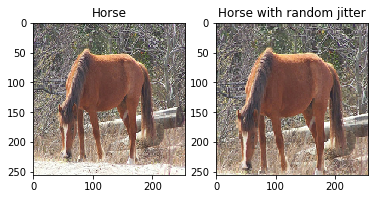

In [104]:
plt.subplot(121)
plt.title('Horse')
plt.imshow(sample_horse[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Horse with random jitter')
plt.imshow(random_jitter(sample_horse[0]) * 0.5 + 0.5)

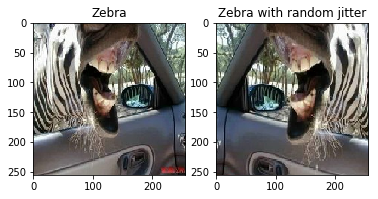

In [105]:
plt.subplot(121)
plt.title('Zebra')
plt.imshow(sample_zebra[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Zebra with random jitter')
plt.imshow(random_jitter(sample_zebra[0]) * 0.5 + 0.5)

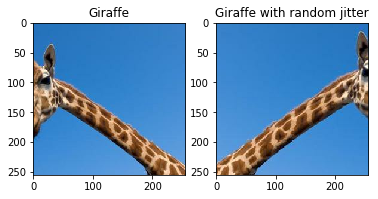

In [106]:
plt.subplot(121)
plt.title('Giraffe')
plt.imshow(sample_giraffe[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Giraffe with random jitter')
plt.imshow(random_jitter(sample_giraffe[0]) * 0.5 + 0.5)

## Import Pix2Pix Generators and Discriminators

Import the generator and the discriminator used in [Pix2Pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py) via the installed [tensorflow_examples](https://github.com/tensorflow/examples) package.

The model architecture used in this tutorial is very similar to what was used in [pix2pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py). Some of the differences are:

* Cyclegan uses [instance normalization](https://arxiv.org/abs/1607.08022) instead of [batch normalization](https://arxiv.org/abs/1502.03167).
* The [CycleGAN paper](https://arxiv.org/abs/1703.10593) uses a modified `resnet` based generator. This tutorial is using a modified `unet` generator for simplicity.

There are 2 generators (G and F) and 2 discriminators (X and Y) being trained here. 

* Generator `G` learns to transform image `X` to image `Y`. $(G: X -> Y)$
* Generator `F` learns to transform image `Y` to image `X`. $(F: Y -> X)$
* Discriminator `D_X` learns to differentiate between image `X` and generated image `X` (`F(Y)`).
* Discriminator `D_Y` learns to differentiate between image `Y` and generated image `Y` (`G(X)`).

![Cyclegan model](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/cyclegan_model.png?raw=1)

In [0]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')



discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

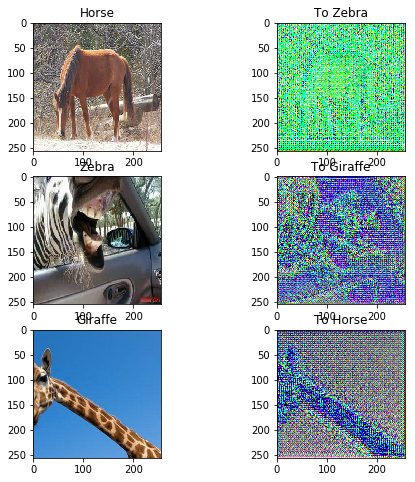

In [108]:
to_zebra = generator_g(sample_horse)
to_horse = generator_f(sample_giraffe)
to_giraffe = generator_f(sample_zebra)
plt.figure(figsize=(8, 8))
contrast = 8

#imgs = [sample_horse, to_zebra, sample_zebra, to_horse] 
imgs = [sample_horse, to_zebra, sample_zebra, to_giraffe, sample_giraffe, to_horse]


#, sample_giraffe, to_zebra]
title = ['Horse', 'To Zebra', 'Zebra', 'To Giraffe', 'Giraffe', 'To Horse']

for i in range(len(imgs)):
  plt.subplot(3, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)

plt.show()

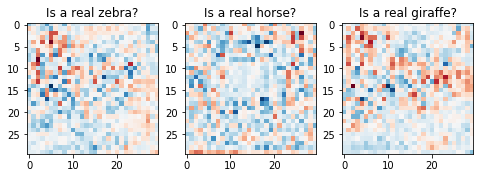

In [109]:
plt.figure(figsize=(8, 8))

plt.subplot(131)
plt.title('Is a real zebra?')
plt.imshow(discriminator_y(sample_zebra)[0, ..., -1], cmap='RdBu_r')

plt.subplot(132)
plt.title('Is a real horse?')
plt.imshow(discriminator_x(sample_horse)[0, ..., -1], cmap='RdBu_r')

plt.subplot(133)
plt.title('Is a real giraffe?')
plt.imshow(discriminator_x(sample_zebra)[0, ..., -1], cmap='RdBu_r')

plt.show()

## Loss functions

In CycleGAN, there is no paired data to train on, hence there is no guarantee that the input `x` and the target `y` pair are meaningful during training. Thus in order to enforce that the network learns the correct mapping, the authors propose the cycle consistency loss.

The discriminator loss and the generator loss are similar to the ones used in [pix2pix](https://www.tensorflow.org/tutorials/generative/pix2pix#define_the_loss_functions_and_the_optimizer).

In [0]:
LAMBDA = 10

In [0]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [0]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

Cycle consistency means the result should be close to the original input. For example, if one translates a sentence from English to French, and then translates it back from French to English, then the resulting sentence should be the same as the  original sentence.

In cycle consistency loss, 

* Image $X$ is passed via generator $G$ that yields generated image $\hat{Y}$.
* Generated image $\hat{Y}$ is passed via generator $F$ that yields cycled image $\hat{X}$.
* Mean absolute error is calculated between $X$ and $\hat{X}$.

$$forward\ cycle\ consistency\ loss: X -> G(X) -> F(G(X)) \sim \hat{X}$$

$$backward\ cycle\ consistency\ loss: Y -> F(Y) -> G(F(Y)) \sim \hat{Y}$$


![Cycle loss](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/cycle_loss.png?raw=1)

In [0]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

As shown above, generator $G$ is responsible for translating image $X$ to image $Y$. Identity loss says that, if you fed image $Y$ to generator $G$, it should yield the real image $Y$ or something close to image $Y$.

$$Identity\ loss = |G(Y) - Y| + |F(X) - X|$$

In [0]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

Here you'll notice we'll be using a Adam o

In [0]:
#!pip install adabound

In [0]:
#Initialize the optimizers for all the generators and the discriminators.
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Checkpoints

In [118]:
checkpoint_path = "/content/drive/My Drive/g2z_40e/checkpoints"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


## Training

As in the Tensorflow Tutorial, I will only be training on 40 epochs. This is simply due to time contraints, as each epoch takes 15 mins, each training session takes roughly 10 hours.

In [0]:
EPOCHS = 40

In [0]:
def generate_images(model, test_input):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

Even though the training loop looks complicated, it consists of four basic steps:

* Get the predictions.
* Calculate the loss.
* Calculate the gradients using backpropagation.
* Apply the gradients to the optimizer.

In [0]:
import pandas as pd

In [0]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
    
  
  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))
  
  # This step is to save all of our loss outputs so we can create a visualization of loss for each epoch
  return gen_g_loss, gen_f_loss, total_cycle_loss, total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss

Now we're going to run a few combinations starting with the  horse and zebra paired domain

In [0]:
# Initializing our loss dataframe
df_loss = pd.DataFrame(columns=['epoch','gen_g_loss', 'gen_f_loss', 'total_cycle_loss', 'total_gen_g_loss',
                                'total_gen_f_loss', 'disc_x_loss', 'disc_y_loss'])


for epoch in range(EPOCHS):
  start = time.time()
 
  # Initailize a new dataframe for each epoch 
  df_average = pd.DataFrame(columns=['gen_g_loss', 'gen_f_loss', 'total_cycle_loss','total_gen_g_loss', 
                                     'total_gen_f_loss', 'disc_x_loss', 'disc_y_loss'])
  
  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_horses, train_zebras)):
    gen_g_loss, gen_f_loss, total_cycle_loss, total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss = train_step(image_x, image_y)
     
    df_average = df_average.append(pd.Series([gen_g_loss.numpy(), gen_f_loss.numpy(), total_cycle_loss.numpy(), total_gen_g_loss.numpy(), total_gen_f_loss.numpy(),
                                              disc_x_loss.numpy(), disc_y_loss.numpy()], index=df_average.columns), ignore_index=True)
    
    # These if statements will be helplful to visualize how far along we are in the training set each epoch
    if n % 10 == 0:
      print ('.', end='')
      
    if n % 100 == 0:
      print ('*', end='')
      
    n+=1

  # After each epoch we're going to add the average losses across the entire training set to our loss dataframe
  df_loss = df_loss.append(pd.Series([epoch, df_average.gen_g_loss.mean(), df_average.gen_f_loss.mean(), df_average.total_cycle_loss.mean(), 
                                      df_average.total_gen_g_loss.mean(), df_average.total_gen_f_loss.mean(), df_average.disc_x_loss.mean(), 
                                      df_average.disc_y_loss.mean()], index=df_loss.columns), ignore_index=True)
 
  
  
  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_horse)
    
  #This is where we should add the loss function outputs to the graph

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  if (epoch + 1) == 10:  
    generator_g.save("/content/drive/My Drive/h2z_40e/Epoch 10/")
    generator_f.save("/content/drive/My Drive/z2h_40e/Epoch 10/")
    print ('Saving models for epoch {}'.format(epoch+1))
  
  if (epoch + 1) == 20:  
    generator_g.save("/content/drive/My Drive/h2z_40e/Epoch 20/")
    generator_f.save("/content/drive/My Drive/z2h_40e/Epoch 20/")
    print ('Saving models for epoch {}'.format(epoch+1))
    
  if (epoch + 1) == 30:  
    generator_g.save("/content/drive/My Drive/h2z_40e/Epoch 30/")
    generator_f.save("/content/drive/My Drive/z2h_40e/Epoch 30/")
    print ('Saving models for epoch {}'.format(epoch+1))
    
  if (epoch + 1) == 40:  
    generator_g.save("/content/drive/My Drive/h2z_40e/Epoch 40/")
    generator_f.save("/content/drive/My Drive/z2h_40e/Epoch 40/")
    print ('Saving models for epoch {}'.format(epoch+1))
  
  
  

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

In [0]:
path = "/content/drive/My Drive/Loss_Dataframe"

#df_loss.to_csv(os.path.join(path,r'h2Z_loss_df.csv'))

h2z_loss_df = pd.read_csv(os.path.join(path,r'h2Z_loss_df.csv'))

## Loss Results


Below we see how the various losses faired across the generators and discriminators. You'll notice the mirror-like nature of the generators and discriminators reflecting the adversarial nature of our network. 

Text(0.5, 1.0, 'Generator Loss Over Epochs')

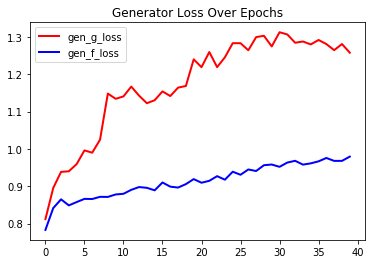

In [9]:
import matplotlib.pyplot as plt


plt.plot( 'epoch', 'gen_g_loss', data=h2z_loss_df, marker='', color='r', linewidth=2)
plt.plot( 'epoch', 'gen_f_loss', data=h2z_loss_df, marker='', color='b', linewidth=2)
plt.legend()
plt.title('Generator Loss Over Epochs')

Text(0.5, 1.0, 'Discriminator Loss Over Epochs')

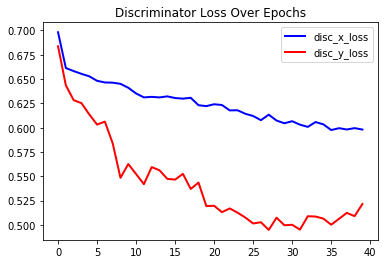

In [10]:
import matplotlib.pyplot as plt


plt.plot( 'epoch', 'disc_x_loss', data=h2z_loss_df, marker='', color='b', linewidth=2)
plt.plot( 'epoch', 'disc_y_loss', data=h2z_loss_df, marker='', color='r', linewidth=2)
plt.legend()
plt.title('Discriminator Loss Over Epochs')

Text(0.5, 1.0, 'Generator and Discriminator Loss Over Epochs')

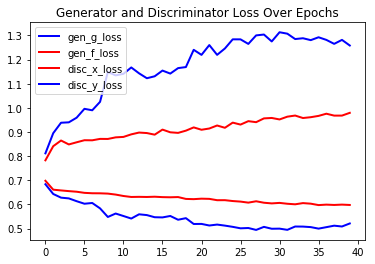

In [12]:
import matplotlib.pyplot as plt


plt.plot( 'epoch', 'gen_g_loss', data=h2z_loss_df, marker='', color='b', linewidth=2)
plt.plot( 'epoch', 'gen_f_loss', data=h2z_loss_df, marker='', color='r', linewidth=2)

plt.plot( 'epoch', 'disc_x_loss', data=h2z_loss_df, marker='', color='r', linewidth=2)
plt.plot( 'epoch', 'disc_y_loss', data=h2z_loss_df, marker='', color='b', linewidth=2)
plt.legend()

plt.title('Generator and Discriminator Loss Over Epochs')

Here you'll see we have an extremely steep loss, showing that our learning rate may be a bit too high. In future iterations, tuning this will allow for a more gradual convergence.

Text(0.5, 1.0, 'Total Generator Loss Over Epochs')

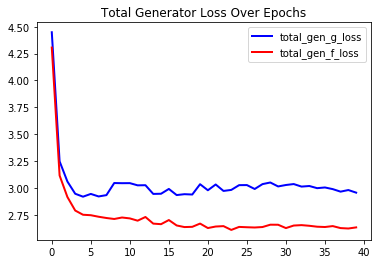

In [15]:
plt.plot( 'epoch', 'total_gen_g_loss', data=h2z_loss_df, marker='', color='b', linewidth=2)
plt.plot( 'epoch', 'total_gen_f_loss', data=h2z_loss_df, marker='', color='r', linewidth=2)
plt.legend()
plt.title('Total Generator Loss Over Epochs')

Text(0.5, 1.0, 'Total Cycle Loss Over Epochs')

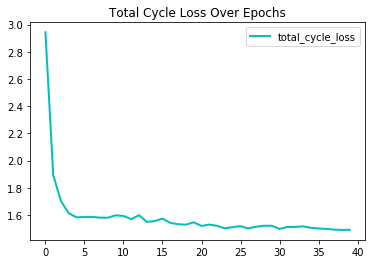

In [13]:
plt.plot( 'epoch', 'total_cycle_loss', data=h2z_loss_df, marker='', color='c', linewidth=2)
plt.legend()
plt.title('Total Cycle Loss Over Epochs')

The next pair is horse and giraffe domain, which will operate identically to our horse to zebra network.

In [0]:
df_loss = pd.DataFrame(columns=['epoch','gen_g_loss', 'gen_f_loss', 'total_cycle_loss', 'total_gen_g_loss',
                                'total_gen_f_loss', 'disc_x_loss', 'disc_y_loss'])


for epoch in range(EPOCHS):
  start = time.time()
 
  df_average = pd.DataFrame(columns=['gen_g_loss', 'gen_f_loss', 'total_cycle_loss','total_gen_g_loss', 
                                     'total_gen_f_loss', 'disc_x_loss', 'disc_y_loss'])
  
  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_horses, train_giraffes)):
    gen_g_loss, gen_f_loss, total_cycle_loss, total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss = train_step(image_x, image_y)
     
    df_average = df_average.append(pd.Series([gen_g_loss.numpy(), gen_f_loss.numpy(), total_cycle_loss.numpy(), total_gen_g_loss.numpy(), total_gen_f_loss.numpy(),
                                              disc_x_loss.numpy(), disc_y_loss.numpy()], index=df_average.columns), ignore_index=True)
    
    
    if n % 10 == 0:
      print ('.', end='')
      
    if n % 100 == 0:
      print ('*', end='')
      
    n+=1

  
  df_loss = df_loss.append(pd.Series([epoch, df_average.gen_g_loss.mean(), df_average.gen_f_loss.mean(), df_average.total_cycle_loss.mean(), 
                                      df_average.total_gen_g_loss.mean(), df_average.total_gen_f_loss.mean(), df_average.disc_x_loss.mean(), 
                                      df_average.disc_y_loss.mean()], index=df_loss.columns), ignore_index=True)
    

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_horse)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  if (epoch + 1) == 10:  
    generator_g.save("/content/drive/My Drive/h2g_40e/Epoch 10/")
    generator_f.save("/content/drive/My Drive/g2h_40e/Epoch 10/")
    print ('Saving models for epoch {}'.format(epoch+1))
  
  if (epoch + 1) == 20:  
    generator_g.save("/content/drive/My Drive/h2g_40e/Epoch 20/")
    generator_f.save("/content/drive/My Drive/g2h_40e/Epoch 20/")
    print ('Saving models for epoch {}'.format(epoch+1))
    
  if (epoch + 1) == 30:  
    generator_g.save("/content/drive/My Drive/h2g_40e/Epoch 30/")
    generator_f.save("/content/drive/My Drive/g2h_40e/Epoch 30/")
    print ('Saving models for epoch {}'.format(epoch+1))
    
  if (epoch + 1) == 40:  
    generator_g.save("/content/drive/My Drive/h2g_40e/Epoch 40/")
    generator_f.save("/content/drive/My Drive/g2h_40e/Epoch 40/")
    print ('Saving models for epoch {}'.format(epoch+1))
  
  
  

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

In [0]:
import pandas as pd
import os

path = "/content/drive/My Drive/Loss_Dataframe"

#df_loss.to_csv(os.path.join(path,r'h2g_loss_df.csv'))

h2g_loss_df = pd.read_csv(os.path.join(path,r'h2g_loss_df.csv'))

Text(0.5, 1.0, 'Generator and Discriminator Loss Over Epochs')

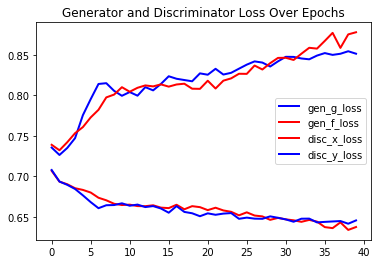

In [16]:
import matplotlib.pyplot as plt


plt.plot( 'epoch', 'gen_g_loss', data=h2g_loss_df, marker='', color='b', linewidth=2)
plt.plot( 'epoch', 'gen_f_loss', data=h2g_loss_df, marker='', color='r', linewidth=2)

plt.plot( 'epoch', 'disc_x_loss', data=h2g_loss_df, marker='', color='r', linewidth=2)
plt.plot( 'epoch', 'disc_y_loss', data=h2g_loss_df, marker='', color='b', linewidth=2)
plt.legend()

plt.title('Generator and Discriminator Loss Over Epochs')

Text(0.5, 1.0, 'Total Generator Loss Over Epochs')

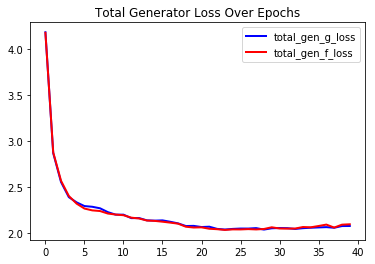

In [17]:
plt.plot( 'epoch', 'total_gen_g_loss', data=h2g_loss_df, marker='', color='b', linewidth=2)
plt.plot( 'epoch', 'total_gen_f_loss', data=h2g_loss_df, marker='', color='r', linewidth=2)
plt.legend()
plt.title('Total Generator Loss Over Epochs')

Text(0.5, 1.0, 'Total Cycle Loss Over Epochs')

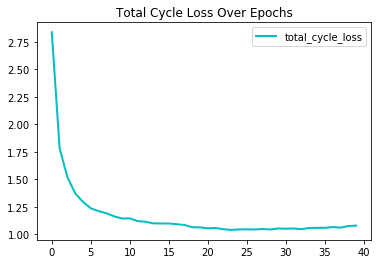

In [18]:
plt.plot( 'epoch', 'total_cycle_loss', data=h2g_loss_df, marker='', color='c', linewidth=2)
plt.legend()
plt.title('Total Cycle Loss Over Epochs')

Lastly, is the zebra and giraffe paired domain.

In [0]:
df_loss = pd.DataFrame(columns=['epoch','gen_g_loss', 'gen_f_loss', 'total_cycle_loss', 'total_gen_g_loss',
                                'total_gen_f_loss', 'disc_x_loss', 'disc_y_loss'])


for epoch in range(EPOCHS):
  start = time.time()
 
  df_average = pd.DataFrame(columns=['gen_g_loss', 'gen_f_loss', 'total_cycle_loss','total_gen_g_loss', 
                                     'total_gen_f_loss', 'disc_x_loss', 'disc_y_loss'])
  
  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_zebras, train_giraffes)):
    gen_g_loss, gen_f_loss, total_cycle_loss, total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss = train_step(image_x, image_y)
     
    df_average = df_average.append(pd.Series([gen_g_loss.numpy(), gen_f_loss.numpy(), total_cycle_loss.numpy(), total_gen_g_loss.numpy(), total_gen_f_loss.numpy(),
                                              disc_x_loss.numpy(), disc_y_loss.numpy()], index=df_average.columns), ignore_index=True)
    
    
    if n % 10 == 0:
      print ('.', end='')
      
    if n % 100 == 0:
      print ('*', end='')
      
    n+=1

  
  df_loss = df_loss.append(pd.Series([epoch, df_average.gen_g_loss.mean(), df_average.gen_f_loss.mean(), df_average.total_cycle_loss.mean(), 
                                      df_average.total_gen_g_loss.mean(), df_average.total_gen_f_loss.mean(), df_average.disc_x_loss.mean(), 
                                      df_average.disc_y_loss.mean()], index=df_loss.columns), ignore_index=True)
    

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_zebra)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  if (epoch + 1) == 10:  
    generator_g.save("/content/drive/My Drive/z2g_40e/Epoch 10/")
    generator_f.save("/content/drive/My Drive/g2z_40e/Epoch 10/")
    print ('Saving models for epoch {}'.format(epoch+1))
  
  if (epoch + 1) == 20:  
    generator_g.save("/content/drive/My Drive/z2g_40e/Epoch 20/")
    generator_f.save("/content/drive/My Drive/g2z_40e/Epoch 20/")
    print ('Saving models for epoch {}'.format(epoch+1))
    
  if (epoch + 1) == 30:  
    generator_g.save("/content/drive/My Drive/z2g_40e/Epoch 30/")
    generator_f.save("/content/drive/My Drive/g2z_40e/Epoch 30/")
    print ('Saving models for epoch {}'.format(epoch+1))
    
  if (epoch + 1) == 40:  
    generator_g.save("/content/drive/My Drive/z2g_40e/Epoch 40/")
    generator_f.save("/content/drive/My Drive/g2z_40e/Epoch 40/")
    print ('Saving models for epoch {}'.format(epoch+1))
  
  
  

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

In [0]:
import pandas as pd
import os

path = "/content/drive/My Drive/Loss_Dataframe"

#df_loss.to_csv(os.path.join(path,r'z2g_loss_df.csv'))

z2g_loss_df = pd.read_csv(os.path.join(path,r'z2g_loss_df.csv'))

In [33]:
'''plt.plot( 'epoch', 'gen_g_loss', data=z2g_loss_df, marker='', color='b', linewidth=2)
plt.plot( 'epoch', 'gen_f_loss', data=z2g_loss_df, marker='', color='r', linewidth=2)

plt.plot( 'epoch', 'disc_x_loss', data=z2g_loss_df, marker='', color='r', linewidth=2)
plt.plot( 'epoch', 'disc_y_loss', data=z2g_loss_df, marker='', color='b', linewidth=2)
plt.legend()

plt.title('Generator and Discriminator Loss Over Epochs')'''

"plt.plot( 'epoch', 'gen_g_loss', data=z2g_loss_df, marker='', color='b', linewidth=2)\nplt.plot( 'epoch', 'gen_f_loss', data=z2g_loss_df, marker='', color='r', linewidth=2)\n\nplt.plot( 'epoch', 'disc_x_loss', data=z2g_loss_df, marker='', color='r', linewidth=2)\nplt.plot( 'epoch', 'disc_y_loss', data=z2g_loss_df, marker='', color='b', linewidth=2)\nplt.legend()\n\nplt.title('Generator and Discriminator Loss Over Epochs')"

In [37]:
'''plt.plot( 'epoch', 'total_gen_g_loss', data=z2g_loss_df, marker='', color='b', linewidth=2)
plt.plot( 'epoch', 'total_gen_f_loss', data=z2g_loss_df, marker='', color='r', linewidth=2)
plt.legend()
plt.title('Total Generator Loss Over Epochs')'''

"plt.plot( 'epoch', 'total_gen_g_loss', data=z2g_loss_df, marker='', color='b', linewidth=2)\nplt.plot( 'epoch', 'total_gen_f_loss', data=z2g_loss_df, marker='', color='r', linewidth=2)\nplt.legend()\nplt.title('Total Generator Loss Over Epochs')"

In [36]:
'''plt.plot( 'epoch', 'total_cycle_loss', data=z2g_loss_df, marker='', color='c', linewidth=2)
plt.legend()
plt.title('Total Cycle Loss Over Epochs')'''

"plt.plot( 'epoch', 'total_cycle_loss', data=z2g_loss_df, marker='', color='c', linewidth=2)\nplt.legend()\nplt.title('Total Cycle Loss Over Epochs')"

## Generate using test dataset

In [0]:
# Run the trained model on the test dataset (Horse to Zebra)
generated_h2z_loaded = tf.keras.models.load_model("/content/drive/My Drive/h2z_40e/Epoch 40/")

for inp in test_horses.take(5):
  generate_images(generated_h2z_loaded, inp)

In [0]:
# Run the trained model on the test dataset (Zebra to Horse)
generated_h2g_loaded = tf.keras.models.load_model("/content/drive/My Drive/h2g_40e/Epoch 40/")

for inp in test_zebras.take(5):
  generate_images(generated_h2g_loaded, inp)

In [0]:
# Run the trained model on the test dataset (Zebra to Giraffe)
generated_z2g_loaded = tf.keras.models.load_model("/content/drive/My Drive/z2g_40e/Epoch 40/")

for inp in test_horse.take(5):
  generate_images(generated_z2g_loaded, inp)

## Analysis

As we can see, our models did an excellent job transfering the style of zebras and giraffes to the horse domain. This is likely due to our models ability to identify the horse object. The same case goes for our models ability to recognize the consistent patterns of the zebra and giraffe. 

![Output Image 1](https://github.com/westontscott/Capstone-Projects/blob/master/Animal2Aminal%20Style%20Transfer/Images/h2g.JPG?raw=1)
![Output Image 1](https://github.com/westontscott/Capstone-Projects/blob/master/Animal2Aminal%20Style%20Transfer/Images/z2g_3.JPG?raw=1)
![Output Image 2](https://github.com/westontscott/Capstone-Projects/blob/master/Animal2Aminal%20Style%20Transfer/Images/h2z_1.JPG?raw=1)
![Output Image 3](https://github.com/westontscott/Capstone-Projects/blob/master/Animal2Aminal%20Style%20Transfer/Images/z2g_6.JPG?raw=1)






One thing our model did a poor job was transfering the style of the horse and zebra onto the giraffe domain. 






![Output Image 5](https://github.com/westontscott/Capstone-Projects/blob/master/Animal2Aminal%20Style%20Transfer/Images/g2h_1.JPG?raw=1)
![Output Image 6](https://github.com/westontscott/Capstone-Projects/blob/master/Animal2Aminal%20Style%20Transfer/Images/z2g_7.JPG?raw=1)



When transferring both horse and zebra, the model had a difficult time dealing with the giraffes long neck, as this is not a feature of either a horse or a zebra. In most cases the model could transfer some of the style to the body of the giraffe, but was generally unsuccessful transferring to anything above the neck



## Improvements

One of the biggest challenges overall was the lack of computing power to run these models on my local machine. As most of this training needed to be parallelized, my GPU wasn't going to cut it. A beefier GPU would be extremely helpful to increase the number of epochs in hopes to improve the model. In addition, it would be helpful in running more complex models that take even longer to train after each batch. Google Colabs runtime maxes out at 12 hours a session and because even these models took roughly 8-10 hours, I would have to upload from a checkpoint in between epochs.

Another thing I would like to try is adding a layer of object detection to the workflow. This could could allow the model to more accurately pinpoint which part of the image needs to be changed, limiting the amount of image degradation in the style transfer process.

It is also possible these images would see vast improvements using the resnet generator as specified in the paper. I was able to find said generator, but with numberous TF 1 "tf.contrib.[...]" depreciation errors, I couldn't afford to waste time going down that rabbit hole translating to TF 2.

Finally, though my google image pipeline was able to support roughly 650 images, there could be vast improvements if I could leverage the API to bring in over 1000 images. Even if there are only a few lines of code need for this process, the hardest part about that would be sifting through drawings, close-ups, and watermarked images.

## Future Research

Now that I have found a way pipe in any image domain I would like, it would be very interesting to see how this model does as we diverge into various species in the animal kingdom. There could even be an interest in a dog2dog style transfer in this world, so keep your eyes open on the iOS and Android app store!

![Output Image 1](https://github.com/westontscott/Capstone-Projects/blob/master/Animal2Aminal%20Style%20Transfer/Images/dog_silhouette.jpg?raw=1)